In [1]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input files
dir_in='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_mur = 'F:/data/sst/jpl_mur/v4.1/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
#################################################################################
#from math import cos, radians



In [2]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750


In [ ]:
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_in, topdown=False):
    #files = [ fi for fi in files if not fi.endswith(".nc") ]
    if root[len(dir_in):len(dir_in)+1]=='.':
        continue
#    if root[len(dir_in):len(dir_in)+4]=='2002':
#        continue
#    for ii in range(12,13): 
    for name in files:
        if not name.endswith('.nc'):
            continue
#        name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
#        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        print(fname_in[36:39],fname_in[31:35])
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm<=2002: # or iyr_storm<2003:
            continue
#        if iyr_storm==2011 and inum_storm<15:
#            continue
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat[0,:]
        lons = dsx.lon[0,:]  #lons goes from 0 to 360
        lons = (lons + 180) % 360 - 180
        dysince = dsx.time
        dsx.close()
        
#make lat and lon of storm onto 25 km grid for below
        lons = (((lons - .125)/.25+1).astype(int)-1)*.25+.125
        lats = (((lats + 89.875)/.25+1).astype(int)-1)*.25-89.875
        
        iwrap=0
        minlon=min(lons.values)-10
#        if minlon<-180.0:
#            minlon+=360.
        maxlon=max(lons.values)+10
#        if maxlon>180.0:
#            maxlon-=360.
        minlat=min(lats.values)-10
        maxlat=max(lats.values)+10
        print('here:',minlon,maxlon)
#        if minlon<10 and maxlon>350:  #wrapping around meridion need to cal new min/max lon
#            minlon=max(lons[lons<180].values)+10
#            maxlon=min(lons[lons>180].values)-10
#            iwrap=1 #set flag for wraparound

        ydim_storm = round((maxlat - minlat)/.25).astype(int)
        new_lat_storm = np.linspace(minlat, maxlat, ydim_storm)
        if (minlon<-90 and maxlon>=90) or (minlon<-180 and maxlon<0):  #this storm wraps  keep everythig 0 to 360 then wrap data at very end
            iwrap = 1
            lons2 = np.mod(lons, 360)
            #minlon = max(lons[lons<0].values)+10
            #maxlon=min(lons[lons>0].values)-10
            #minlon += 360
            #maxlon2 = maxlon
            #minlon, maxlon = maxlon2, minlon
            minlon, maxlon = min(lons2.values)-10, max(lons2.values)+10
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)
        else:
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)

        print(iwrap,minlon,maxlon)
        print(iwrap,xdim_storm, new_lon_storm[:5],new_lon_storm[-5:])

        
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        minjdy = min(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min(tem_date).year #create new time array that can be queried for year etc
        minmon =min(tem_date).month #create new time array that can be queried for year etc
        minday =min(tem_date).day #create new time array that can be queried for year etc
        maxjdy = max(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max(tem_date).year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30             #calculate ssts for 30 days after storm

        #print(tdim,xdim,ydim)      
                      
        #print('sst_out_sv',sst_out_sv.shape)
        for i in range(0,tdim):
            storm_date = dt.datetime(minyear,minmon,minday)+dt.timedelta(days=i)+dt.timedelta(hours=12)
            #print(storm_date)
            
            syr=str(storm_date.year)
            smon=str(storm_date.month)
            sdym=str(storm_date.day)
            sjdy=str(storm_date.timetuple().tm_yday)

#sst data   
            fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
            filename = dir_cmc + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
            ds_day=xr.open_dataset(filename,drop_variables=['analysis_error','sea_ice_fraction'])
            if iwrap==1:  #data is -180 to 180 for sst, so need to bring to 0 to 360 when wrapped
                ds_day.coords['lon'] = np.mod(ds_day['lon'], 360)
                ds_day = ds_day.sortby(ds_day.lon)
            ds_day.close()
            ds_day = ds_day.where(ds_day['mask'] == 1.) 
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            #ds_storm['time']=storm_date
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            if i==0:
                ds_storm_sst = ds_storm
            else:
                ds_storm_sst = xr.concat([ds_storm_sst,ds_storm],dim='time')

#sst climatology
            if storm_date.timetuple().tm_yday==366:
                sjdy = '365'
            filename='F:/data/sst/cmc/CMC0.2deg/v2/climatology/clim1993_2016' + sjdy.zfill(3) + '-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
            ds_day=xr.open_dataset(filename,drop_variables=['analysis_error','sea_ice_fraction','sq_sst'])
            ds_day = ds_day.rename({'analysed_sst':'analysed_sst_clim','mask':'mask_clim'}) #, inplace = True)            
            if iwrap==1:  #data is -180 to 180 for sst, so need to bring to 0 to 360 when wrapped
                ds_day.coords['lon'] = np.mod(ds_day['lon'], 360)
                ds_day = ds_day.sortby(ds_day.lon)
            ds_day.close()
            ds_day = ds_day.where(ds_day['mask_clim'] == 1.) 
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            if i==0:
                ds_storm_sst_clim = ds_storm
            else:
                ds_storm_sst_clim = xr.concat([ds_storm_sst_clim,ds_storm],dim='time')           
            
#ccmp wind data, no masked data, a complete field
            dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
#            lyr, idyjl = 2015,1
#            storm_date = dt.datetime(2015,1,1)
            syr, smon, sdym, sjdy=str(storm_date.year),str(storm_date.month),str(storm_date.day),str(storm_date.timetuple().tm_yday)
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      
            ds=xr.open_dataset(ccmp_filename,drop_variables=['nobs'])
            ds_day = ds.mean(dim='time')     #take average across all 6 hourly data fields
            ds_day = ds_day.rename({'longitude':'lon','latitude':'lat'}) #, inplace = True)            
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if i==0:
                ds_storm_ccmp = ds_storm
            else:
                ds_storm_ccmp = xr.concat([ds_storm_ccmp,ds_storm],dim='time')
              
#ocean mixed layer depth from monthly data GODAS NOAA, lon 0 to 360, monthly data so interp to day
            #dir_godas='https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/godas/'
            dir_godas = 'f:/data/model_data/godas/'
            if isave_mld_year != storm_date.year:
                filename = dir_godas + 'dbss_obml.' + syr + '.nc'
                ds_day_mld=xr.open_dataset(filename)
                if iwrap==0:
                    ds_day_mld.coords['lon'] = (ds_day_mld.coords['lon'] + 180) % 360 - 180
                    ds_day_mld = ds_day_mld.sortby(ds_day_mld.lon)
                ds_day_mld.close()
                isave_mld_year = storm_date.year
            ds_storm = ds_day_mld.interp(time = storm_date, lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm = ds_storm.assign_coords(time=storm_date)
            if i==0:
                ds_storm_mld = ds_storm
            else:
                ds_storm_mld = xr.concat([ds_storm_mld,ds_storm],dim='time')            
            
#latent heat flux data, masked already set to NaN                
            filename = dir_flux + 'lh_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_lhf = ds_storm
            else:
                ds_storm_lhf = xr.concat([ds_storm_lhf,ds_storm],dim='time')

#sensible heat flux data , masked already set to NaN                
            filename = dir_flux + 'sh_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_shf = ds_storm
            else:
                ds_storm_shf = xr.concat([ds_storm_shf,ds_storm],dim='time')

#surface humid flux data   , masked already set to NaN              
            filename = dir_flux + 'qa_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_qa = ds_storm
            else:
                ds_storm_qa = xr.concat([ds_storm_qa,ds_storm],dim='time')

#air temp flux data   , masked already set to NaN              
            filename = dir_flux + 'ta_oaflux_' + syr + '.nc';
            ds=xr.open_dataset(filename,drop_variables=['err'])
            ds_day = ds.sel(time = storm_date.timetuple().tm_yday)  #select day of year from annual file
            if iwrap==0:
                ds_day.coords['lon'] = (ds_day.coords['lon'] + 180) % 360 - 180
                ds_day = ds_day.sortby(ds_day.lon)
            ds.close()
            ds_storm = ds_day.interp(lat = new_lat_storm,lon = new_lon_storm)
            if iwrap==1:
                ds_storm.coords['lon'] = (ds_storm.coords['lon'] + 180) % 360 - 180
            ds_storm['time']=storm_date
            if i==0:
                ds_storm_ta = ds_storm
            else:
                ds_storm_ta = xr.concat([ds_storm_ta,ds_storm],dim='time')
                
        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst, ds_storm_sst_clim])
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
     # filename = dir_out + str(iyr_storm) + '/' + 'str(inum_storm)' + '_other_data.nc'
    


001 2002
002 2002
005 2002
007 2002
009 2002
010 2002
011 2002
012 2002
013 2002
014 2002
015 2002
017 2002
018 2002
019 2002
020 2002
021 2002
022 2002
023 2002
025 2002
027 2002
028 2002
030 2002
031 2002
033 2002
034 2002
035 2002
036 2002
037 2002
039 2002
040 2002
041 2002
042 2002
043 2002
046 2002
047 2002
048 2002
049 2002
050 2002
051 2002
052 2002
053 2002
054 2002
055 2002
056 2002
058 2002
060 2002
061 2002
063 2002
064 2002
066 2002
067 2002
068 2002
069 2002
070 2002
072 2002
075 2002
077 2002
081 2002
082 2002
083 2002
084 2002
002 2003
002annual_storm_info.nc f:/data/tc_wakes/database/info/2003\002annual_storm_info.nc
here: 38.375 88.125
0 38.375 88.125
0 199 [38.375      38.62626263 38.87752525 39.12878788 39.38005051] [87.11994949 87.37121212 87.62247475 87.87373737 88.125     ]
2002 318 2002 331
out: f:/data/tc_wakes/database/sst/2003/002_combined_data.nc
003 2003
003annual_storm_info.nc f:/data/tc_wakes/database/info/2003\003annual_storm_info.nc
here: -188.375 -123.

out: f:/data/tc_wakes/database/sst/2003/027_combined_data.nc
028 2003
028annual_storm_info.nc f:/data/tc_wakes/database/info/2003\028annual_storm_info.nc
here: 112.125 170.125
0 112.125 170.125
0 232 [112.125      112.37608225 112.6271645  112.87824675 113.129329  ] [169.120671   169.37175325 169.6228355  169.87391775 170.125     ]
2003 99 2003 115
out: f:/data/tc_wakes/database/sst/2003/028_combined_data.nc
031 2003
031annual_storm_info.nc f:/data/tc_wakes/database/info/2003\031annual_storm_info.nc
here: -78.875 -12.375
0 -78.875 -12.375
0 266 [-78.875      -78.6240566  -78.37311321 -78.12216981 -77.87122642] [-13.37877358 -13.12783019 -12.87688679 -12.6259434  -12.375     ]
2003 108 2003 117
out: f:/data/tc_wakes/database/sst/2003/031_combined_data.nc
032 2003
032annual_storm_info.nc f:/data/tc_wakes/database/info/2003\032annual_storm_info.nc
here: 37.875 75.125
0 37.875 75.125
0 149 [37.875      38.12668919 38.37837838 38.63006757 38.88175676] [74.11824324 74.36993243 74.62162162 74

out: f:/data/tc_wakes/database/sst/2003/065_combined_data.nc
066 2003
066annual_storm_info.nc f:/data/tc_wakes/database/info/2003\066annual_storm_info.nc
here: -75.125 -16.875
0 -75.125 -16.875
0 233 [-75.125      -74.87392241 -74.62284483 -74.37176724 -74.12068966] [-17.87931034 -17.62823276 -17.37715517 -17.12607759 -16.875     ]
2003 239 2003 252
out: f:/data/tc_wakes/database/sst/2003/066_combined_data.nc
067 2003
067annual_storm_info.nc f:/data/tc_wakes/database/info/2003\067annual_storm_info.nc
here: 100.625 149.375
0 100.625 149.375
0 195 [100.625      100.87628866 101.12757732 101.37886598 101.63015464] [148.36984536 148.62113402 148.87242268 149.12371134 149.375     ]
2003 239 2003 246
out: f:/data/tc_wakes/database/sst/2003/067_combined_data.nc
070 2003
070annual_storm_info.nc f:/data/tc_wakes/database/info/2003\070annual_storm_info.nc
here: 114.875 163.375
0 114.875 163.375
0 194 [114.875      115.12629534 115.37759067 115.62888601 115.88018135] [162.36981865 162.62111399 16

2003 338 2003 343
out: f:/data/tc_wakes/database/sst/2003/095_combined_data.nc
097 2003
097annual_storm_info.nc f:/data/tc_wakes/database/info/2003\097annual_storm_info.nc
here: 70.875 100.375
0 70.875 100.375
0 118 [70.875      71.12713675 71.3792735  71.63141026 71.88354701] [ 99.36645299  99.61858974  99.8707265  100.12286325 100.375     ]
2003 345 2003 350
out: f:/data/tc_wakes/database/sst/2003/097_combined_data.nc
001 2004
001annual_storm_info.nc f:/data/tc_wakes/database/info/2004\001annual_storm_info.nc
here: 53.125 77.375
0 53.125 77.375
0 97 [53.125      53.37760417 53.63020833 53.8828125  54.13541667] [76.36458333 76.6171875  76.86979167 77.12239583 77.375     ]
2003 271 2003 277
out: f:/data/tc_wakes/database/sst/2004/001_combined_data.nc
002 2004
002annual_storm_info.nc f:/data/tc_wakes/database/info/2004\002annual_storm_info.nc
here: 41.875 88.875
0 41.875 88.875
0 188 [41.875      42.1263369  42.3776738  42.6290107  42.88034759] [87.86965241 88.1209893  88.3723262  88.62

out: f:/data/tc_wakes/database/sst/2004/025_combined_data.nc
026 2004
026annual_storm_info.nc f:/data/tc_wakes/database/info/2004\026annual_storm_info.nc
here: 78.375 101.875
0 78.375 101.875
0 94 [78.375      78.62768817 78.88037634 79.13306452 79.38575269] [100.86424731 101.11693548 101.36962366 101.62231183 101.875     ]
2004 137 2004 140
out: f:/data/tc_wakes/database/sst/2004/026_combined_data.nc
028 2004
028annual_storm_info.nc f:/data/tc_wakes/database/info/2004\028annual_storm_info.nc
here: 106.125 186.875
0 106.125 186.875
0 323 [106.125      106.3757764  106.6265528  106.87732919 107.12810559] [185.87189441 186.12267081 186.3734472  186.6242236  186.875     ]
2004 156 2004 166
out: f:/data/tc_wakes/database/sst/2004/028_combined_data.nc
029 2004
029annual_storm_info.nc f:/data/tc_wakes/database/info/2004\029annual_storm_info.nc
here: 91.875 142.125
0 91.875 142.125
0 201 [91.875   92.12625 92.3775  92.62875 92.88   ] [141.12    141.37125 141.6225  141.87375 142.125  ]
2004 15

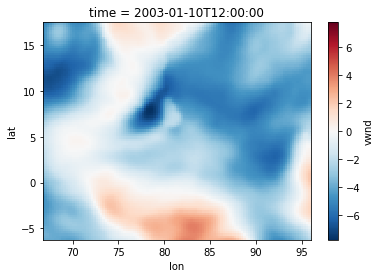

In [12]:
ds_storm_ccmp.vwnd[20,:,:].plot()

In [14]:
filename2 = 'f:/data/model_data/godas/dbss_obml.2002.nc'
ds_day_mld=xr.open_dataset(filename2)
ds_day_mld.close()
ds_day_mld

<xarray.Dataset>
Dimensions:    (lat: 418, lon: 360, time: 12)
Coordinates:
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float32 -74.5 -74.16667 -73.83334 ... 64.16566 64.499
  * time       (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2002-12-01
Data variables:
    date       (time) int32 ...
    timePlot   (time) float32 ...
    dbss_obml  (time, lat, lon) float32 ...
Attributes:
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    Conventions:      COARDS
    grib_file:        godas.M.200201-12.grb
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    comment:          NOTE:  THESE ARE THE BIAS CORRE

In [6]:
isave_mld_year

2001

In [ ]:
print(dir_godas + 'dbss_obml.' + syr + '.nc')
ds_day=xr.open_dataset(dir_godas + 'dbss_obml.' + syr + '.nc')

In [ ]:
#OLD CODE using netcdf and calculating location directly rather than using xarray
###### dir_mur = 'F:/data/sst/jpl_mur/v4.1/'
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm>2003 or iyr_storm<2003:
            continue
#        if iyr_storm==2011 and inum_storm<15:
#            continue
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat[0,:]
        lons = dsx.lon[0,:]  #lons goes from 0 to 360
        dysince = dsx.time
        #minlon=min(lons[0,:].values)-10
        #maxlon=max(lons[0,:].values)+10
        #minlat=min(lats[0,:].values)-10
        #maxlat=max(lats[0,:].values)+10
        
        iwrap=0
        minlon=min(lons.values)-10
        maxlon=max(lons.values)+10
        minlat=min(lats.values)-10
        maxlat=max(lats.values)+10
        if minlon<10 and maxlon>350:  #wrapping around meridion need to cal new min/max lon
            minlon=max(lons[lons<180].values)+10
            maxlon=min(lons[lons>180].values)-10
            iwrap=1 #set flag for wraparound
        
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
#        iwrap=0
#        print('first and last!',lons[0,1].values,lons[0,-1].values)
#        if abs(min(lons[0,:].values)-max(lons[0,:].values))>180:
#            lons1=lons[0,:].values-10>180
#            lons2=lons[0,:].values+10<180
#            maxlon=min(lons[0,lons1].values-10)
#            minlon=max(lons[0,lons2].values+10)
#            print('wrapped',minlon,maxlon)
#            iwrap=1
            #wrap_lons = ((lons+180) % 360) - 180        
            #maxlon=max(wrap_lons[0,:].values)+10 #this will find the positive maximum
            #minlon=min(wrap_lons[0,:].values)-10
            #if minlon<0:
            #    maxlon=min(wrap_lons[0,:].values)-10+360
            #    minlon=max(wrap_lons[0,:].values)+10

        print('min/max lon lat',minlon,maxlon,minlat,maxlat)

        ix1=int(round((minlon-dx_offset)/dx))
        ix2=int(round((maxlon-dx_offset)/dx))
        iy1=int(round((minlat-dy_offset)/dy))
        iy2=int(round((maxlat-dy_offset)/dy))
        if iy2 > 628:
            iy2=628
        if iy1 < 1:
            iy1=1    
        if ix1 < 0:
            ix1 = ix1 + 1440
        if ix2 < 0:
            ix2 = ix2 + 1440
        print(minlon,maxlon,minlat,maxlat)
        xdim=ix2-ix1
        if iwrap==1:  #wraps around so make sure xdim reflects that
            xdim=ix1-ix2+1440
        ydim=iy2-iy1
        
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        minjdy = min(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min(tem_date).year #create new time array that can be queried for year etc
        maxjdy = max(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max(tem_date).year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30


        print(tdim,ix1,ix2,iy1,iy2,xdim,ydim)      
               
        sst_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        sst_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndu_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndv_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndu_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndv_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        
        print('sst_out_sv',sst_out_sv.shape)
        for i in range(0,tdim):
            storm_date = tem_date[0]+dt.timedelta(days=i)
            #print(storm_date)
            
            syr=str(storm_date.year)
            smon=str(storm_date.month)
            sdym=str(storm_date.day)
            sjdy=str(storm_date.timetuple().tm_yday)
            
            fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
            mur_filename = dir_mur + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
            
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      

            #flux data
            lh_flux_filename = dir_flux + 'lh_oaflux_' + syr + '.nc';
            sh_flux_filename = dir_flux + 'sh_oaflux_' + syr + '.nc';
            ta_flux_filename = dir_flux + 'ta_oaflux_' + syr + '.nc';
            qa_flux_filename = dir_flux + 'qa_oaflux_' + syr + '.nc';
  #          fname='F:\data\model_data\oaflux\data_v3\daily\radiation_1985-2009\sw_isccp_2004.nc';
 #           [nswrs]=ncread(fname,'nswrs',[1 1 idy],[360 180 1]);
            
            if storm_date.timetuple().tm_yday==366:
                sjdy = '365'
            clim_filename='F:/data/sst/jpl_mur/v4.1/clim/clim2_' + sjdy.zfill(3) +'_2003_2013_MUR-GLOB-v02.0-fv04.1.nc'
            ccmp_clim_filename='F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_' + sjdy.zfill(3) +'.nc'
#            print(ccmp_filename)
#            print(ccmp_clim_filename)

#ccmp wind            
            nc_fid = Dataset(ccmp_filename, 'r')
            nc_fid2 = Dataset(ccmp_clim_filename, 'r') 
            tem = nc_fid.variables['uwnd'][:,iy1:iy2,:]  #read in data all longitude, limited latitude
            tem = np.mean(tem,axis=0)                     #take average across all 6 hourly data fields
            wndu = np.append(tem[:,ydim:],tem[:,:ydim], axis=1) #switch from 0-360 to -180 to 180  ydim is half of xdim
            tem = nc_fid.variables['vwnd'][:,iy1:iy2,:]
            tem = np.mean(tem,axis=0)
            wndv = np.append(tem[:,ydim:],tem[:,:ydim], axis=1)               
            mlat_ccmp = nc_fid.variables['latitude'][iy1:iy2]
            tem = nc_fid.variables['longitude'][:]
            mlon_ccmp = np.append(tem[ydim:],tem[:ydim], axis=0)  
            mlon_save = mlon_ccmp[:]
            mlon_ccmp = ((mlon_ccmp - 180) % 360) - 180  #make -180 to 180 rather than 0 360
            tem = nc_fid2.variables['av_u'][iy1:iy2,:]
            wndu_clim = np.append(tem[:,ydim:],tem[:,:ydim], axis=1)               
            tem = nc_fid2.variables['av_v'][iy1:iy2,:]
            wndv_clim = np.append(tem[:,ydim:],tem[:,:ydim], axis=1)               
            nc_fid.close()
            nc_fid2.close()           


            #flux data
            ds = xr.open_dataset(lh_flux_filename)
            ds_subset = ds.sel(time = idyjl)
            ds_res = ds_subset.interp(latitude = new_lat,longitude = mlon_save)
           # nc_fid4 = Dataset(sh_flux_filename, 'r')
           # nc_fid5 = Dataset(ta_flux_filename, 'r')
           # nc_fid6 = Dataset(qa_flux_filename, 'r')

            #[lhf1]=ncread(fname,'lhtfl',[1 1 idy],[360 180 1]);
            #[Tair1]=ncread(fname,'tmp2m',[1 1 idy],[360 180 1]);
            #[Qair1]=ncread(fname,'hum2m',[1 1 idy],[360 180 1]);  
            #[shf1]=ncread(fname,'shtfl',[1 1 idy],[360 180 1]);

            
            
            
#            if i==0:
#                print('i=0',iy1,iy2,ix1,ix2,iy2-iy1,ix2-ix1)
            if ix1<=1440 and ix2<=1440 and iwrap==0:
#                if i==0:
#                    print('inside1',iy1,iy2,ix1,ix2)
                wndu_out = wndu[:,ix1:ix2]
                wndu_clim_out = wndu_clim[:,ix1:ix2]
                wndv_out = wndv[:,ix1:ix2]
                wndv_clim_out = wndv_clim[:,ix1:ix2]
            if ix1>1440 and ix2>1440 and iwrap==0:
 #               if i==0:
#                    print('inside2',iy1,iy2,ix1,ix2)
                wndu_out = wndu[:,ix1-1440:ix2-1440]
                wndu_clim_out = wndu_clim[:,ix1-1440:ix2-1440]
                wndv_out = wndv[:,ix1-1440:ix2-1440]
                wndv_clim_out = wndv_clim[:,ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440 and iwrap==0:
#                if i==0:
#                    print('inside3',iy1,iy2,ix1,ix2)

                tem1 = wndu[:,ix1:]
                tem2 = wndu[:,:ix2-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[:,ix1:]
                tem2 = wndv[:,:ix2-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[:,ix1:]
                tem2 = wndu_clim[:,:ix2-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[:,ix1:]
                tem2 = wndv_clim[:,:ix2-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)

            if ix1<=1440 and ix2>1440 and iwrap==1:
#                if i==0:
#                    print('inside1',iy1,iy2,ix1,ix2)
                wndu_out = wndu[:,ix2-1440:ix1]
                wndu_clim_out = wndu_clim[:,ix2-1440:ix1]
                wndv_out = wndv[:,ix2-1440:ix1]
                wndv_clim_out = wndv_clim[:,ix2-1440:ix1]

            wndu_out_sv[i,:,:]=wndu_out
            wndv_out_sv[i,:,:]=wndv_out
            wndu_clim_out_sv[i,:,:]=wndu_clim_out
            wndv_clim_out_sv[i,:,:]=wndv_clim_out
            
#sst data   

            nc_fid = Dataset(mur_filename, 'r')
            mlat = nc_fid.variables['lat'][1149:16849]
            ilat_mur1 = np.argmin(abs(mlat-mlat_ccmp.min()))-12
            #print('mlat first point:', mlat[ilat_mur1_tem])
            ilat_mur2 = np.argmin(abs(mlat-mlat_ccmp.max()))+13
            mlat = mlat[ilat_mur1:ilat_mur2]
            sst = nc_fid.variables['analysed_sst'][0,ilat_mur1:ilat_mur2,:]
            mlon = nc_fid.variables['lon'][:]
            nc_fid.close()

            nc_fid2 = Dataset(clim_filename, 'r')                      
            sst_clim = nc_fid2.variables['sst'][ilat_mur1:ilat_mur2,:]
            nc_fid2.close()
                       
            coarseness = 25
            temp = mlon.reshape((mlon.shape[0] // coarseness, coarseness))
            coarse_mlon = np.mean(temp, axis=(1), dtype=np.float64)
            temp = mlat.reshape((mlat.shape[0] // coarseness, coarseness))
            coarse_mlat = np.mean(temp, axis=(1), dtype=np.float64)
            temp = sst.reshape((sst.shape[0] // coarseness, coarseness, sst.shape[1] // coarseness, coarseness))
            coarse_sst = np.mean(temp, axis=(1,3), dtype=np.float64)
            temp = sst_clim.reshape((sst_clim.shape[0] // coarseness, coarseness, sst_clim.shape[1] // coarseness, coarseness))
            coarse_sst_clim = np.mean(temp, axis=(1,3), dtype=np.float64)

            #need to recalculate iy1 and iy2 because of offset made earlier to read less of file
#            iy1=np.argmin(abs(coarse_mlat-minlat))
#            iy2=np.argmin(abs(coarse_mlat-maxlat))
#            ydim=iy2-iy1   
#            print(coarse_mlat[0],coarse_mlat[-1])
#            print(iy1,iy2,ydim,minlat,maxlat)

#            if i==0:
#                print('i=0',ix1,ix2,iy2-iy1,ix2-ix1)
            if ix1<=1440 and ix2<=1440 and iwrap==0:
#                if i==0:
#                    print('inside1',ix1,ix2)
                sst_out = coarse_sst[:,ix1:ix2]
                mlat_out = coarse_mlat[:]
                mlon_out = coarse_mlon[ix1:ix2]
                sst_clim_out = coarse_sst_clim[:,ix1:ix2]
            if ix1>1440 and ix2>1440 and iwrap==0:
#                if i==0:
#                    print('inside2',ix1,ix2)
                sst_out = coarse_sst[:,ix1-1440:ix2-1440]
                mlat_out = coarse_mlat[:]
                mlon_out = coarse_mlon[ix1-1440:ix2-1440]
                sst_clim_out = coarse_sst_clim[:,ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440 and iwrap==0:
#                if i==0:
#                    print('inside3',ix1,ix2)
                tem1 = coarse_sst[:,ix1:]
                tem2 = coarse_sst[:,:ix2-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[:]
                mlon1 = coarse_mlon[ix1:]
                mlon2 = coarse_mlon[:ix2-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                tem1 = coarse_sst_clim[:,ix1:]
                tem2 = coarse_sst_clim[:,:ix2-1440]
                sst_clim_out = np.append(tem1,tem2, axis=1)

            if ix1<=1440 and ix2>1440 and iwrap==1:
 #               if i==0:
 #                   print('inside1',ix1,ix2)
                sst_out = coarse_sst[:,ix2-1440:ix1]
                mlat_out = coarse_mlat[:]
                mlon_out = coarse_mlon[ix2-1440:ix1]
                sst_clim_out = coarse_sst_clim[:,ix2-1440:ix1]

            if i==0:
                print('sst',sst_out.shape,'coarse',coarse_sst.shape,wndu_out.shape)
                print('sst',sst_out.shape,'sst_sv',sst_out_sv.shape)
                print('mlon',mlon_out.shape,'mlat',mlat_out.shape)
            #sst_sv[i,:,:]=sst-sst_clim
            sst_out_sv[i,:,:]=sst_out
            sst_clim_out_sv[i,:,:]=sst_clim_out


  
 
            
            
        ilen=len(fname_in)
        
        dif_dys=[0]*tdim
        for i in range(0,tdim):
            dif_dys[i] = i

        print('file out:',fname_out)
        #f.close()
        f = Dataset(fname_out,'w', format='NETCDF4') 
        tempgrp = f.createGroup('data')
        tempgrp.setncattr_string('start time',str(tem_date[0]))
        tempgrp.createDimension('t', tdim)
        tempgrp.createDimension('y', ydim)
        tempgrp.createDimension('x', xdim)

    #tem_date[i]
        sst_netcdf = tempgrp.createVariable('sst', 'f4', ('t', 'y', 'x'))
        sst_clim_netcdf = tempgrp.createVariable('sst_clim', 'f4', ('t', 'y', 'x'))
        wndu_netcdf = tempgrp.createVariable('wndu', 'f4', ('t', 'y', 'x'))
        wndv_netcdf = tempgrp.createVariable('wndv', 'f4', ('t', 'y', 'x'))
        wndu_clim_netcdf = tempgrp.createVariable('wndu_clim', 'f4', ('t', 'y', 'x'))
        wndv_clim_netcdf = tempgrp.createVariable('wndv_clim', 'f4', ('t', 'y', 'x'))
        longitude = tempgrp.createVariable('lon', 'f4', 'x')
        latitude = tempgrp.createVariable('lat', 'f4', 'y')  
        time = tempgrp.createVariable('time', 'i4', 't')
        
        sst_netcdf[:] = sst_out_sv
        sst_clim_netcdf[:] = sst_clim_out_sv
        wndu_netcdf[:] = wndu_out_sv
        wndv_netcdf[:] = wndv_out_sv
        wndu_clim_netcdf[:] = wndu_clim_out_sv
        wndv_clim_netcdf[:] = wndv_clim_out_sv
        latitude[:] = mlat_out
        longitude[:] = mlon_out
        time[:]=dif_dys
        f.close()
    
